In [1]:
# basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hour, day, MW
import sys

# osier imports
from osier import CapacityExpansion
import osier.tech_library as lib

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize


# set the solver based on operating system -- assumes glpk or cbc is installed.
if "win32" in sys.platform:
    solver = 'cplex'
elif "linux" in sys.platform:
    solver = "cbc"
elif "darwin" in sys.platform:
    solver = 'cplex_direct'
else:
    solver = "cbc"

print(f"Solver set: {solver}")

Solver set: cplex_direct


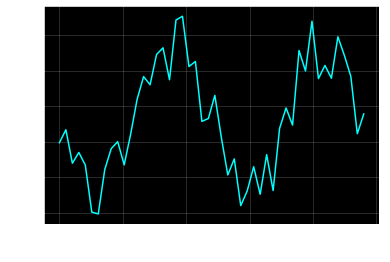

In [2]:
#demand profile
n_hours = 24  # hours per day
n_days = 2  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)
total_demand = 185  # [MWh], sets the total demand [units of energy]

demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

np.random.seed(1234) # sets the seed for repeatability

noise = np.random.random(N)
demand += noise

demand = demand/demand.sum() * total_demand  # rescale

with plt.style.context("dark_background"):
    plt.plot(hours, demand, color='cyan')
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.grid(alpha=0.2)
    plt.show()

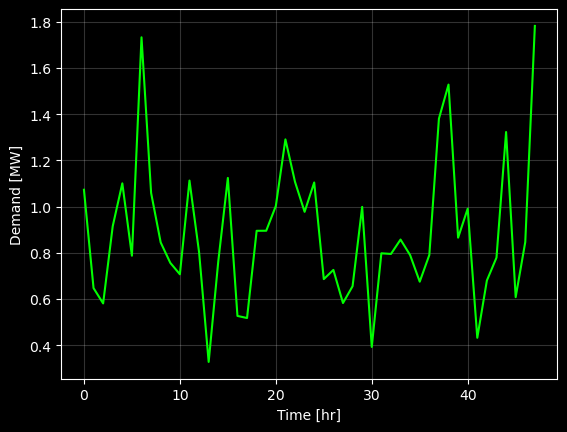

In [3]:
#wind profile
np.random.seed(123)
shape_factor = 2.5
wind_speed = np.random.weibull(a=shape_factor,size=N)

with plt.style.context('dark_background'):
    plt.plot(wind_speed, color='lime')
    plt.grid(alpha=0.2)
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.show()

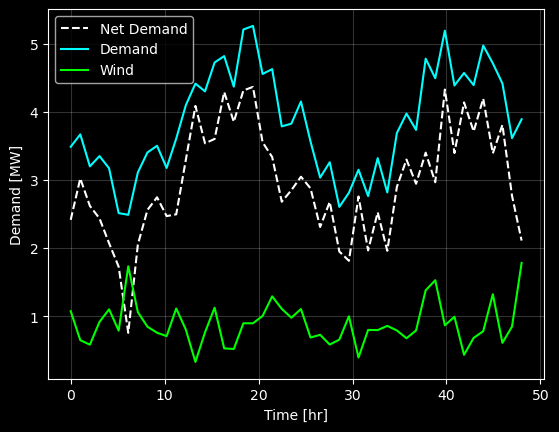

In [4]:
with plt.style.context('dark_background'):
    plt.plot(hours, demand-wind_speed, color='white', linestyle='--', label='Net Demand')
    plt.plot(hours, demand, color='cyan', label='Demand')
    plt.plot(hours, wind_speed, color='lime', label='Wind')
    plt.grid(alpha=0.2)
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.legend()
    plt.show()

In [5]:
technologies = [lib.battery, lib.wind]
technologies

[Battery: 815.3412599999999 MW, WindTurbine: 0.0 MW]

In [6]:
from osier import total_cost
problem = CapacityExpansion(technology_list = [lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            objectives = [total_cost],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [7]:
algorithm = NSGA2(pop_size=20)

import time
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



KeyboardInterrupt: 

In [10]:
display(res.F, res.X)

array([0.25723553])

array([0.70666673, 0.31068083])

In [11]:
from osier import DispatchModel
lib.battery.capacity =  res.X[1]*demand.max()*MW
lib.natural_gas.capacity = res.X[0]*demand.max()*MW

technologies = [lib.natural_gas, lib.battery]
display(technologies)

model = DispatchModel(technology_list=technologies,
                      net_demand=demand)
model.solve(solver=solver)

[NaturalGas_Conv: 3.7188949914308496 MW, Battery: 1.6349848215023173 MW]

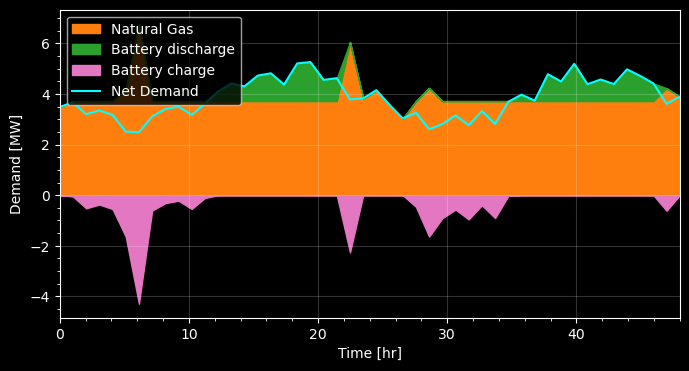

In [12]:
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.grid(alpha=0.2)
    ax.minorticks_on()
    ax.fill_between(hours,
                    y1=0,
                    y2=model.results['NaturalGas_Conv'].values,
                    color='tab:orange',
                    label='Natural Gas')
    ax.fill_between(hours,
                    y1=model.results['NaturalGas_Conv'].values,
                    y2=model.results['Battery'].values+model.results['NaturalGas_Conv'].values,
                    color='tab:green',
                    label='Battery discharge')
    ax.fill_between(hours,
                    y1=0,
                    y2=model.results['Battery_charge'].values,
                    color='tab:pink',
                    label='Battery charge')
    ax.plot(hours, model.net_demand, color='cyan', label='Net Demand')
    ax.set_xlim(0,48)
    # ax.set_ylim(0,5.5)
    ax.legend(loc='upper left')
    ax.set_ylabel("Demand [MW]")
    ax.set_xlabel("Time [hr]")
    plt.show()

In [13]:
problem = CapacityExpansion(technology_list = [lib.wind, lib.battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [14]:
algorithm = NSGA2(pop_size=20)

import time
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      1 |             - |             -
     2 |       40 |      1 |  0.000000E+00 |             f
     3 |       60 |      1 |  0.0731198079 |         ideal
     4 |       80 |      1 |  0.000000E+00 |             f
     5 |      100 |      1 |  0.0023483205 |             f
     6 |      120 |      1 |  0.0255449274 |         ideal
     7 |      140 |      1 |  0.000000E+00 |             f
     8 |      160 |      1 |  0.000000E+00 |             f
     9 |      180 |      1 |  0.000000E+00 |             f
    10 |      200 |      1 |  0.0002146070 |             f
The simulation took 2.495 minutes.


In [15]:
technologies = []
for X,tech in zip(res.X,problem.technology_list):
    tech.capacity = X*problem.max_demand
    technologies.append(tech)
display(technologies)
# normalize the wind speed
wind_speed = (wind_speed / wind_speed.max()) * res.X[0]*problem.max_demand
net_dem = demand*MW - wind_speed
display(f"Max wind production: {wind_speed.max()}")

model = DispatchModel(technology_list=[technologies[1]],
                      net_demand=net_dem)
model.solve(solver=solver)

[WindTurbine: 10.135967781702929 MW, Battery: 2.7950442069865686 MW]

'Max wind production: 10.135967781702929 MW'

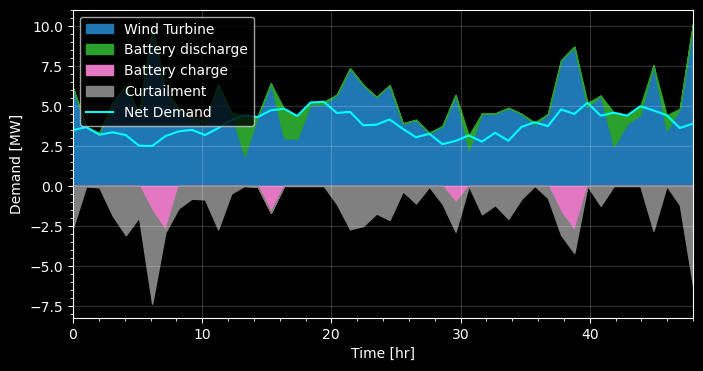

In [16]:
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.grid(alpha=0.2)
    ax.minorticks_on()
    ax.fill_between(hours,
                    y1=0,
                    y2=np.array(wind_speed),
                    color='tab:blue',
                    label='Wind Turbine')
    ax.fill_between(hours,
                    y1=np.array(wind_speed),
                    y2=model.results['Battery'].values+np.array(wind_speed),
                    color='tab:green',
                    label='Battery discharge')
    ax.fill_between(hours,
                    y1=0,
                    y2=model.results['Battery_charge'].values,
                    color='tab:pink',
                    label='Battery charge')
    ax.fill_between(hours,
                    y1=model.results['Battery_charge'].values,
                    y2=model.results['Battery_charge'].values+model.results['Curtailment'].values,
                    color='gray',
                    label='Curtailment')
    ax.plot(hours, demand, color='cyan', label='Net Demand')
    ax.set_xlim(0,48)
    # ax.set_ylim(0,5.5)
    ax.legend(loc='upper left')
    ax.set_ylabel("Demand [MW]")
    ax.set_xlabel("Time [hr]")
    plt.show()

In [17]:
from osier import annual_emission

# the default emission is `lifecycle_co2_rate`

In [19]:
problem = CapacityExpansion(technology_list = [lib.wind, lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            solver=solver)  # the objectives must be passed as a LIST of functions!


In [20]:
algorithm = NSGA2(pop_size=20)

import time
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      6 |             - |             -
     2 |       40 |      4 |  0.0158631600 |         nadir
     3 |       60 |      6 |  0.0046803095 |         nadir
     4 |       80 |     13 |  0.0075483249 |         ideal
     5 |      100 |     11 |  0.0286189131 |         ideal
     6 |      120 |     16 |  0.0143108624 |             f
     7 |      140 |     19 |  0.0038096294 |         ideal
     8 |      160 |     20 |  0.0123935102 |             f
     9 |      180 |     20 |  0.0488020532 |         nadir
    10 |      200 |     20 |  0.0176305030 |             f
The simulation took 4.723 minutes.


In [21]:
display(res.F)

array([[1.19945119e+00, 4.48339838e-06],
       [5.20590010e-01, 4.22836313e-05],
       [5.94956650e-01, 3.31273855e-05],
       [6.39785553e-01, 2.43974512e-05],
       [7.08193933e-01, 1.88392322e-05],
       [1.03741440e+00, 5.01230980e-06],
       [6.76877772e-01, 2.19705621e-05],
       [7.63720969e-01, 1.58503836e-05],
       [8.60297364e-01, 1.15062221e-05],
       [5.53008596e-01, 3.79200939e-05],
       [8.09557178e-01, 1.54093261e-05],
       [9.93427512e-01, 7.06494074e-06],
       [8.48928279e-01, 1.35553105e-05],
       [9.43233259e-01, 1.05890851e-05],
       [9.84786540e-01, 8.96392716e-06],
       [1.03492980e+00, 5.01576659e-06],
       [5.23407779e-01, 4.19378638e-05],
       [9.56761295e-01, 1.01734674e-05],
       [5.33459304e-01, 3.95948803e-05],
       [5.43811675e-01, 3.82503908e-05]])

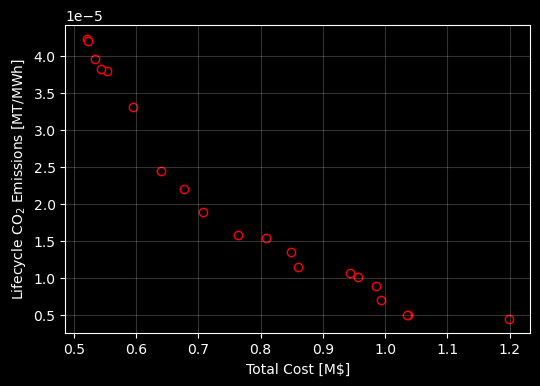

In [22]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    plt.show()

In [23]:
display(res.X)

array([[2.53341702, 0.04144996, 0.55710663],
       [0.81401452, 0.41946283, 0.30094145],
       [0.97601979, 0.40287869, 0.35417943],
       [1.1384407 , 0.39580232, 0.25387131],
       [1.30377163, 0.39488571, 0.25098929],
       [2.11218424, 0.09849739, 0.56117257],
       [1.21045201, 0.42561055, 0.25098929],
       [1.42508911, 0.41533998, 0.24747279],
       [1.66520048, 0.39488571, 0.25098929],
       [0.8920409 , 0.41946283, 0.30094145],
       [1.47365324, 0.50706447, 0.25557499],
       [2.03385808, 0.29352286, 0.26963251],
       [1.56593795, 0.50884959, 0.25559555],
       [1.75907345, 0.48251036, 0.34948459],
       [1.88970608, 0.50711056, 0.25422291],
       [2.10823443, 0.09849739, 0.55725319],
       [0.82023035, 0.42580387, 0.29455337],
       [1.79151691, 0.48189384, 0.34948459],
       [0.86380735, 0.41930255, 0.26382456],
       [0.88775931, 0.41930255, 0.26573897]])

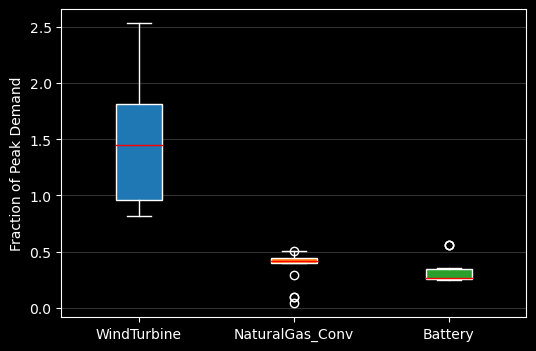

In [24]:
from osier import get_tech_names
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    bplot = ax.boxplot(res.X,
                       patch_artist=True,
                       labels=get_tech_names(problem.technology_list))
    ax.set_ylabel("Fraction of Peak Demand")

    # fill with colors
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in bplot['medians']:
        median.set_color('red')

    ax.yaxis.grid(True, alpha=0.2)
    plt.show()

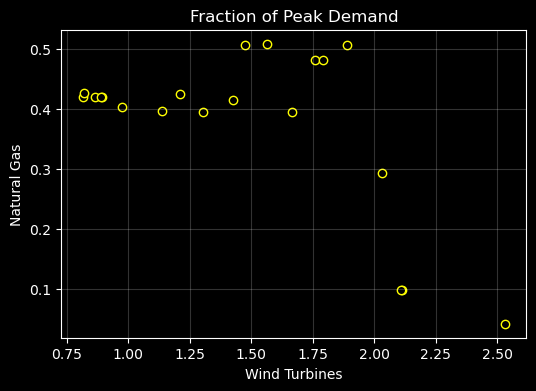

In [26]:

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.X[:,0], res.X[:,1], edgecolors='yellow', facecolors='k')
    ax.set_ylabel(r"Natural Gas")
    ax.set_xlabel(r"Wind Turbines")
    ax.set_title("Fraction of Peak Demand")
    ax.grid(alpha=0.2)

    plt.show()